In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [18]:
# Cargar los datos desde el archivo CSV
data = pd.read_csv("./data/etecsa_processed.csv")
pairwise_distances = pd.read_csv("./data/pairwise_distances.csv")

In [19]:
# Ordenar los datos por usuario, día y tiempo de inicio
data = data.sort_values(by=['user_index', 'day', 'time_start'])

# Agrupar por usuario y día
grouped = data.groupby(['user_index', 'day'])

# Función para procesar cada grupo
def process_group(group):
    zones = group['zone'].to_numpy()
    time_start = group['time_start'].to_numpy()
    time_end = group['time_end'].to_numpy()
    
    t_time = time_end[-1] - time_start[0]
    
    # Cálculo vectorizado para f_time
    f_time = (time_start[1:-1] - time_start[0]) / t_time

    try:
        d = pairwise_distances[(pairwise_distances['origin'] == zones[0]) & (pairwise_distances['destiny'] == zones[-1])]['distance'].values[0]
    except:
        return None

    # Crear DataFrame para las trayectorias procesadas
    processed = pd.DataFrame({
        'zone_start': zones[0],
        'zone_middle': zones[1:-1],
        'zone_end': zones[-1],
        'f_time': f_time,
        'distance': ('near' if d < 6 else ('far' if d > 8 else 'medium')),
    })
    return processed

# Aplicar la función a cada grupo y concatenar los resultados
processed_trajectories = grouped.apply(process_group)

# Eliminar el índice adicional generado por el groupby
processed_trajectories.reset_index(drop=True, inplace=True)

C:\Users\alexs\AppData\Local\Temp\ipykernel_23176\329516711.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_trajectories = grouped.apply(process_group)


In [17]:
for distance, group in processed_trajectories.groupby(['distance']):
    print(distance[0], len(group))
    processed_trajectories.to_csv(f"./data/{distance[0]}_processed_trajectories.csv", index=False)

far 157343
medium 337735
near 150924


In [ ]:
# Guardar los datos procesados en un nuevo archivo CSV
processed_trajectories.to_csv("./data/processed_trajectories.csv", index=False)

In [ ]:
# Cargar el archivo shapefile
shp_file = 'data/havana_shape/havana_transport_zones.shp'
data = gpd.read_file(shp_file)

# Calcular los centroides
data['centroid'] = data.geometry.centroid

# Extraer las coordenadas (latitud y longitud)
data['latitude'] = data['centroid'].y
data['longitude'] = data['centroid'].x

zones_centroids = data[['No_de_zona', 'latitude', 'longitude']].rename(columns={'No_de_zona': 'zone'})

# Mostrar los primeros registros
zones_centroids.head()

zones_centroids.to_csv("./data/zones_centroids.csv", index=False)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

trip_groups = data.groupby(['user_index', 'day'])
trip_distances = []

# Para cada viaje, ordenar por time_start y extraer la zona de origen y destino
for (user, day), group in trip_groups:
    group_sorted = group.sort_values(by='time_start')
    origin_zone = group_sorted.iloc[0]['zone']
    destiny_zone = group_sorted.iloc[-1]['zone']
    
    # Verificar que ambas zonas existan en el grafo
    # if origin_zone in G.nodes() and destiny_zone in G.nodes():
    try:
        # Calcular el camino más corto en el grafo usando la suma de distancias (pesos)
        d = pairwise_distances[(pairwise_distances['origin'] == origin_zone) & (pairwise_distances['destiny'] == destiny_zone)]['distance'].values[0]
        trip_distances.append(d)
    except:
        pass

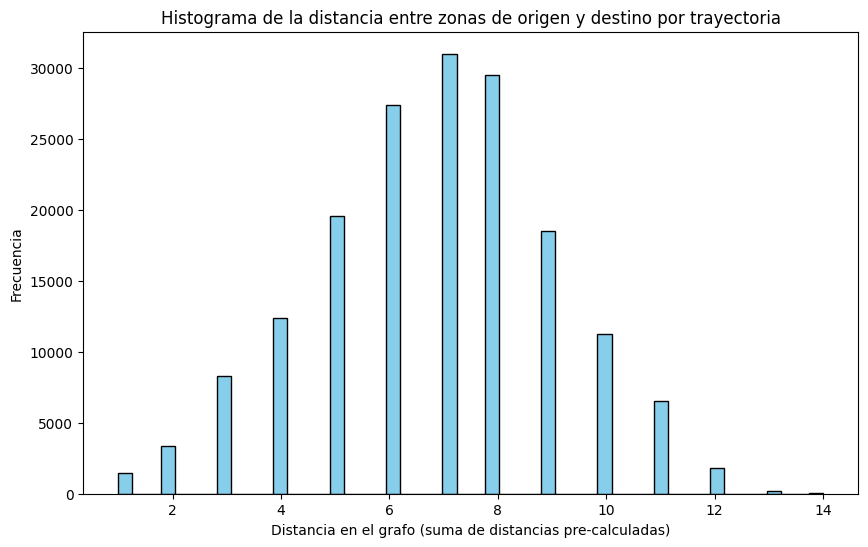

In [8]:
plt.figure(figsize=(10,6))
plt.hist(trip_distances, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Distancia en el grafo (suma de distancias pre-calculadas)')
plt.ylabel('Frecuencia')
plt.title('Histograma de la distancia entre zonas de origen y destino por trayectoria')
plt.show()

[Text(0, 0.1, ''),
 Text(0, 0.2, ''),
 Text(0, 0.30000000000000004, ''),
 Text(0, 0.4, ''),
 Text(0, 0.5, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.7000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 0.9, '')]

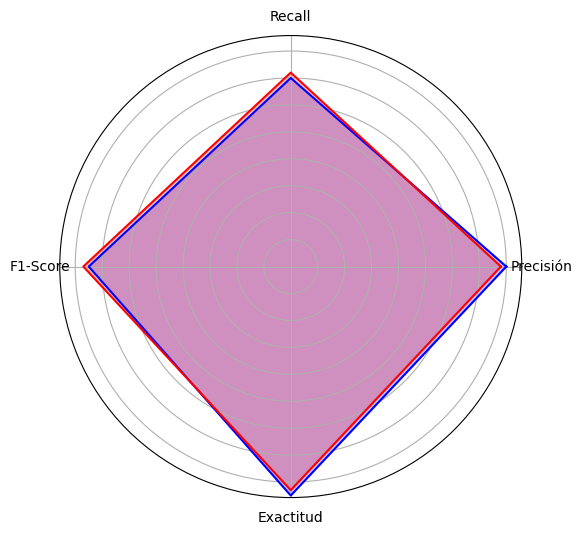

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
metricas = ['Precisión', 'Recall', 'F1-Score', 'Exactitud']
valores_modelo1 = [0.8, 0.7, 0.75, 0.85]
valores_modelo2 = [0.78, 0.72, 0.77, 0.83]

# Añadir la primera métrica al final para cerrar el círculo
valores_modelo1 += valores_modelo1[:1]
valores_modelo2 += valores_modelo2[:1]

# Ángulos para cada métrica
angulos = np.linspace(0, 2 * np.pi, len(metricas), endpoint=False).tolist()
angulos += angulos[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.fill(angulos, valores_modelo1, color='blue', alpha=0.25)
ax.plot(angulos, valores_modelo1, color='blue', label='Modelo 1')

ax.fill(angulos, valores_modelo2, color='red', alpha=0.25)
ax.plot(angulos, valores_modelo2, color='red', label='Modelo 2')

ax.set_xticks(angulos[:-1])
ax.set_xticklabels(metricas)
ax.set_yticklabels([])
# ax.set_title('Comparación de Modelos en Mé
# ::contentReference[oaicite:0]{index=0}
 
